In [1]:
import tensorflow as tf
%load_ext tensorboard
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
import datetime
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statistics
!rm -rf ./logs/ 
print(tf.__version__) #Double check the colab has the instance of tensorflow we want

2.15.1


# Import the Dataset

In [2]:
lab_data = pd.read_csv('../../data/83_Loeschcke_et_al_2000_Thorax_&_wing_traits_lab pops.csv')

# Data cleaning
lab_data = lab_data[lab_data['Thorax_length'] != '.']

In [3]:
lab_data['Thorax_length'] = pd.to_numeric(lab_data['Thorax_length'])
lab_data['wing_loading'] = pd.to_numeric(lab_data['wing_loading'])

In [4]:
lab_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1730 entries, 0 to 1730
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Species        1730 non-null   object 
 1   Population     1730 non-null   object 
 2   Latitude       1730 non-null   float64
 3   Longitude      1730 non-null   float64
 4   Year_start     1730 non-null   int64  
 5   Year_end       1730 non-null   int64  
 6   Temperature    1730 non-null   int64  
 7   Vial           1730 non-null   int64  
 8   Replicate      1730 non-null   int64  
 9   Sex            1730 non-null   object 
 10  Thorax_length  1730 non-null   float64
 11  l2             1730 non-null   float64
 12  l3p            1730 non-null   float64
 13  l3d            1730 non-null   float64
 14  lpd            1730 non-null   float64
 15  l3             1730 non-null   float64
 16  w1             1730 non-null   float64
 17  w2             1730 non-null   float64
 18  w3           

In [5]:
lab_data = shuffle(lab_data)
lab_data['class'] = lab_data.apply(
    lambda x: f"{x['Species']}, {x['Population']}",
    axis=1
)

# encode class labels to integers
lab_data['class'] = lab_data['class'].astype('category').cat.codes

train, test = train_test_split(lab_data, test_size=0.3)

lab_data.head()

,Species,Population,Latitude,Longitude,Year_start,Year_end,Temperature,Vial,Replicate,Sex,...,l2,l3p,l3d,lpd,l3,w1,w2,w3,wing_loading,class
201,D._aldrichi,Gogango_Creek,-23.77,150.17,1994,1994,20,7,3,female,...,1.769,0.574,1.582,2.157,2.155,0.988,1.331,1.091,1.833,1
1066,D._buzzatii,Gogango_Creek,-23.77,150.17,1994,1994,20,8,3,male,...,1.841,0.605,1.563,2.167,2.166,0.956,1.347,1.075,1.870,6
1605,D._buzzatii,Wahruna,-25.20,151.17,1994,1994,20,9,3,female,...,1.931,0.670,1.608,2.278,2.278,0.988,1.397,1.106,1.860,9
800,D._aldrichi,Wahruna,-25.20,151.17,1994,1994,30,3,2,female,...,1.608,0.578,1.362,1.941,1.940,0.874,1.177,0.985,1.731,4
1139,D._buzzatii,Gogango_Creek,-23.77,150.17,1994,1994,30,1,1,female,...,1.735,0.586,1.492,2.077,2.077,0.900,1.273,1.005,1.935,6


### Create tensor batches

In [6]:

#cifar_x_train = cifar_x_train.astype(np.float32)
#cifar_x_test = cifar_x_test.astype(np.float32)

train_ds = tf.data.Dataset.from_tensor_slices(
    (
    train[['Thorax_length', 'l2', 'l3p', 'l2', 'l3p', 'l2', 'l3p', 'l2', 'l3p', 'l2', 'l3p', 'wing_loading']],
    train[['class']]
    )
).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices(
    (
    test[['Thorax_length', 'l2', 'l3p', 'l2', 'l3p', 'l2', 'l3p', 'l2', 'l3p', 'l2', 'l3p', 'wing_loading']],
    test[['class']]
    )
).batch(32)


In [7]:
class ModelTester:
    def __init__(
        self,
        model_name,
        model, 
        optimiser = None,
        loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    ):
        self._model = model
        self.model_name = model_name
        if optimiser is None:
            self._optimiser = tf.keras.optimizers.legacy.Adam() 
        self._loss_object = loss_object
        self._train_loss = tf.keras.metrics.Mean(name='train_loss')
        self._train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    
        self._test_loss = tf.keras.metrics.Mean(name='test_loss')
        self._test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
    
        self._training_results = []
        self._training_set_accuracy = []
        self._test_set_accuracy = []
        self._mean_training_accuracy = []
        self._mean_test_accuracy = []
  
    @tf.function
    def train_step(self, images, labels):
        with tf.GradientTape() as tape:
            # training=true is only needed if there are layers with different
            # behavior during training versus inference (e.g. dropout).
            predictions = self._model(images, training=True)
            loss = self._loss_object(labels, predictions)
        gradients = tape.gradient(loss, self._model.trainable_variables)
        self._optimiser.apply_gradients(zip(gradients, self._model.trainable_variables))
        
        self._train_loss(loss)
        self._train_accuracy(labels, predictions) 
    
    @tf.function
    def test_step(self, images, labels):
        # training=False is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = self._model(images, training=False)
        t_loss = self._loss_object(labels, predictions)
        
        self._test_loss(t_loss)
        self._test_accuracy(labels, predictions)
    
    def train(self, train_ds, test_ds, epochs):
        for epoch in range(epochs):
            # Reset the metrics at the start of the next epoch
            self._train_loss.reset_state()
            self._train_accuracy.reset_state()
            self._test_loss.reset_state()
            self._test_accuracy.reset_state()
            
            for images, labels in train_ds:
                self.train_step(images, labels)
            
            for test_images, test_labels in test_ds:
                self.test_step(test_images, test_labels)

            self._training_set_accuracy.append(float(self._train_accuracy.result()))
            self._test_set_accuracy.append(float(self._test_accuracy.result()))
            '''
            template = 'Model: {}, Epoch: {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
            print(template.format(
                self.model_name,
                epoch + 1,
                self._train_loss.result(),
                self._train_accuracy.result() * 100,
                self._test_loss.result(),
                self._test_accuracy.result() * 100)
            )
            '''

            if len(self._training_set_accuracy) < 10:
                mean_training_accuracy = statistics.fmean(self._training_set_accuracy)
            else:
                mean_training_accuracy = statistics.fmean(self._training_set_accuracy[-10:])

            if len(self._test_set_accuracy) < 10:
                mean_test_set_accuracy = statistics.fmean(self._test_set_accuracy)
            else:
                mean_test_set_accuracy = statistics.fmean(self._test_set_accuracy[-10:])
            
            self._training_results.append({
                'epoch': epoch + 1,
                'training_set_loss': float(self._train_loss.result()),
                'mean_training_set_accuracy': mean_training_accuracy,
                'training_set_accuracy': float(self._train_accuracy.result()),
                'test_set_loss': float(self._test_loss.result()),
                'mean_test_set_accuracy': mean_test_set_accuracy,
                'test_set_accuracy': float(self._test_accuracy.result()) 
            })
            
            if epoch % 500 == 0:
                print(f'Epoch: {epoch + 1}')

        #print(self._training_results)
        training_results_df = pd.DataFrame(self._training_results)
        #print(training_results_df.head())
        training_results_df.plot(kind='line', x='epoch', y='mean_training_set_accuracy')
        plt.show()
        training_results_df.plot(kind='line', x='epoch', y='training_set_accuracy')
        plt.show()
        training_results_df.plot(kind='line', x='epoch', y='mean_test_set_accuracy')
        plt.show()
        training_results_df.plot(kind='line', x='epoch', y='test_set_accuracy')
        plt.show()

    def get_final_test_set_accuracy(self):
        return float(self._test_accuracy.result())

Epoch: 1
Epoch: 501
Epoch: 1001


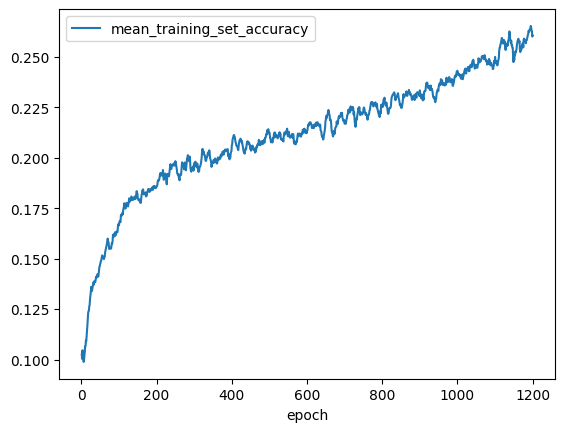

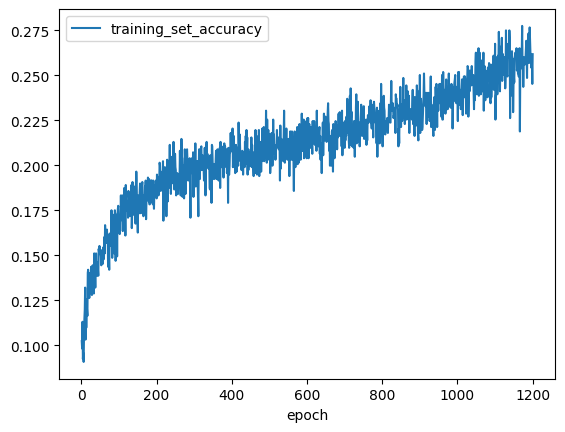

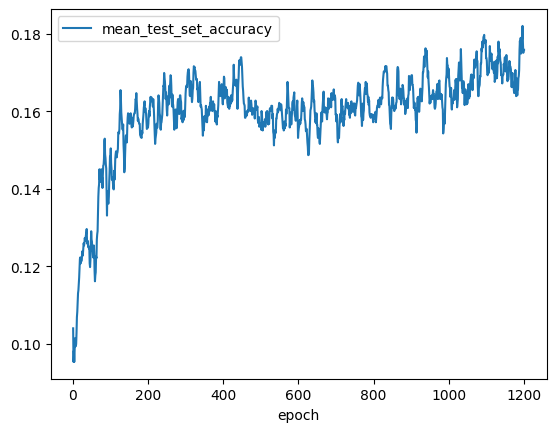

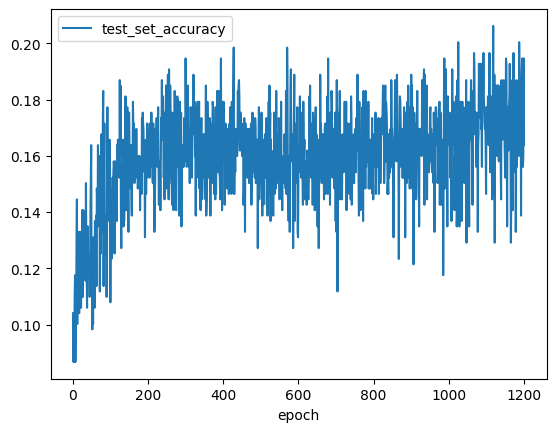

In [8]:

dual_layer_softmax_model =  tf.keras.models.Sequential([
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax') # 20 possible classes (2 species, 5 populations, 2 sexes)
])


tester_dual_layer_softmax = ModelTester('Single Convolution layer', dual_layer_softmax_model)
tester_dual_layer_softmax.train(train_ds, test_ds, 1200)
test_set_accuracy_128 = tester_dual_layer_softmax.get_final_test_set_accuracy()

Epoch: 1
Epoch: 501
Epoch: 1001


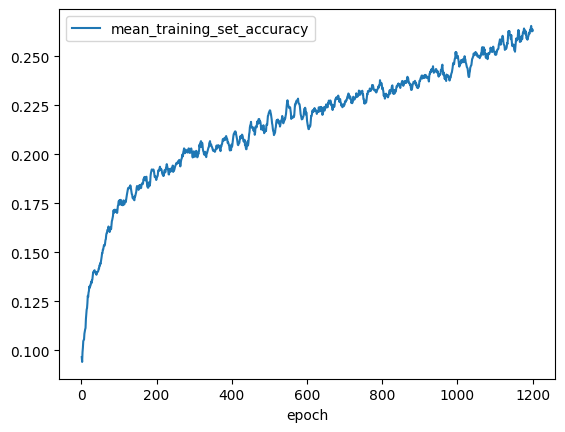

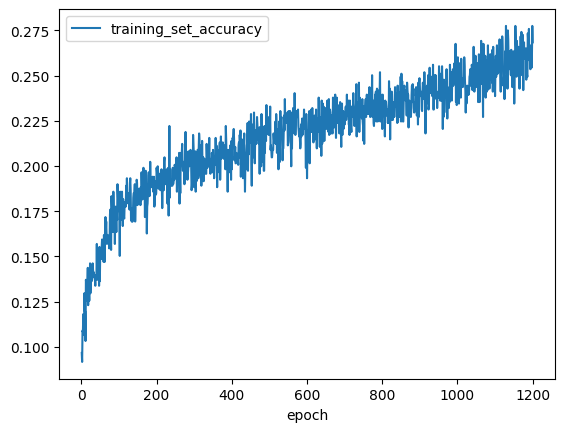

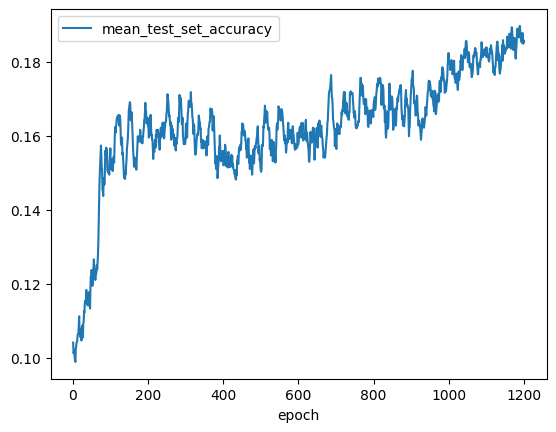

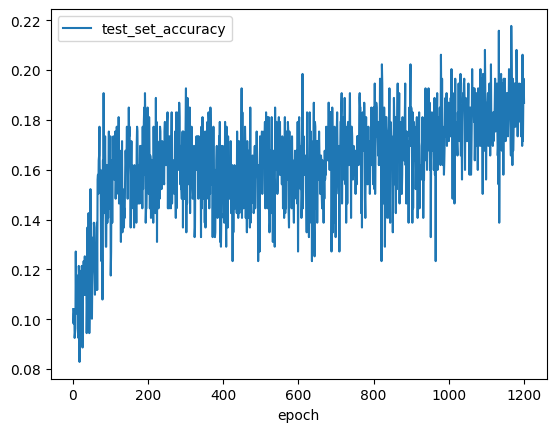

In [9]:

dual_layer_softmax_model =  tf.keras.models.Sequential([
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax') # 20 possible classes (2 species, 5 populations, 2 sexes)
])


tester_dual_layer_softmax = ModelTester('Single Convolution layer', dual_layer_softmax_model)
tester_dual_layer_softmax.train(train_ds, test_ds, 1200)
test_set_accuracy_256 = tester_dual_layer_softmax.get_final_test_set_accuracy()

Epoch: 1
Epoch: 501
Epoch: 1001


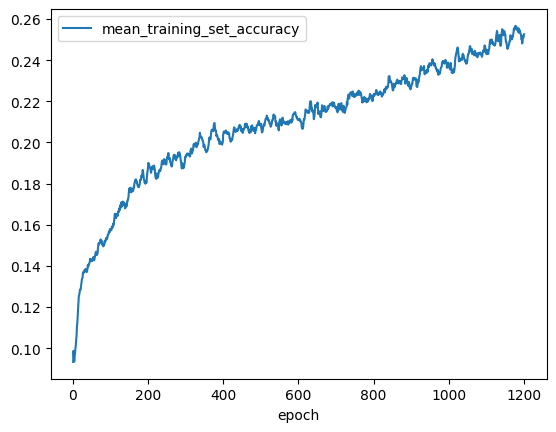

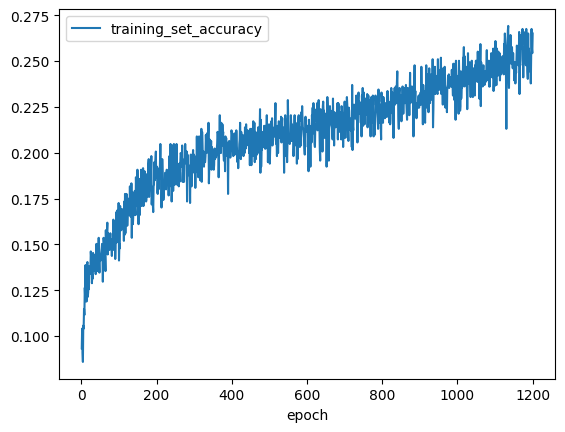

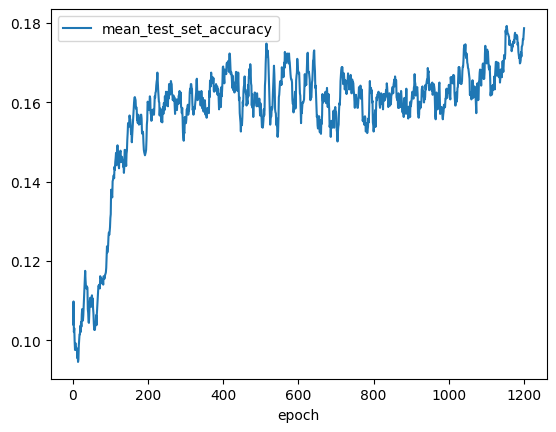

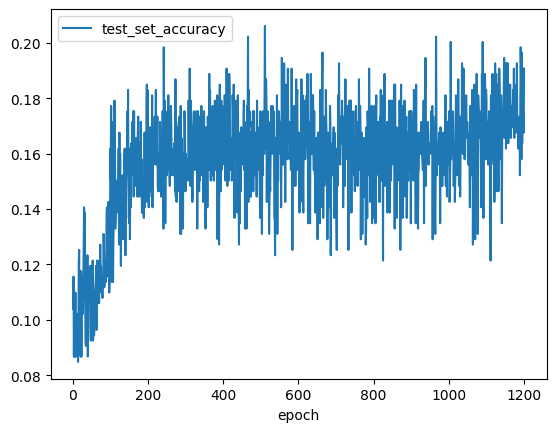

In [10]:
dual_layer_softmax_model =  tf.keras.models.Sequential([
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax') # 5 possible classes (5 populations)
])

tester_dual_layer_softmax = ModelTester('Single Convolution layer', dual_layer_softmax_model)
tester_dual_layer_softmax.train(train_ds, test_ds, 1200)
test_set_accuracy_512 = tester_dual_layer_softmax.get_final_test_set_accuracy()

Epoch: 1
Epoch: 501
Epoch: 1001


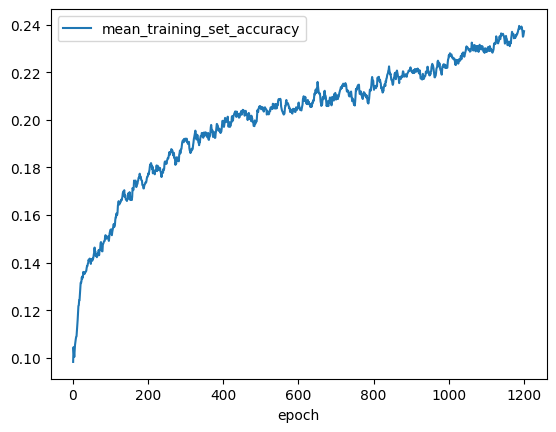

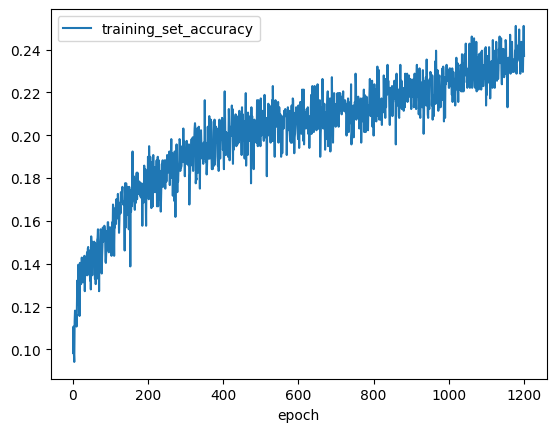

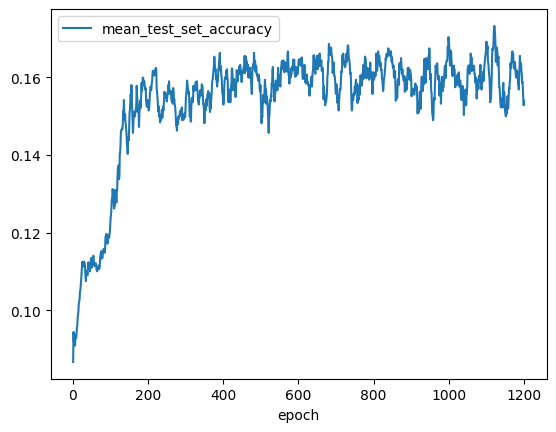

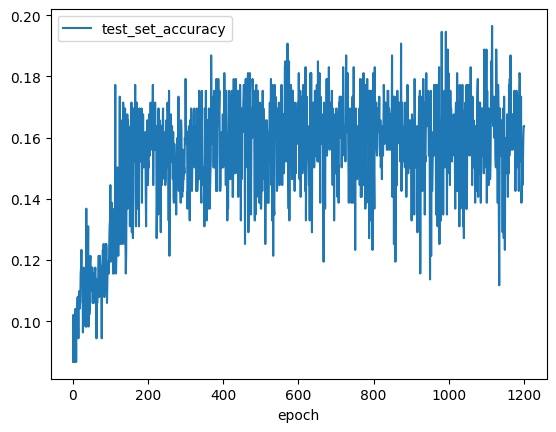

In [11]:
dual_layer_softmax_model =  tf.keras.models.Sequential([
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax') # 5 possible classes (5 populations)
])

tester_dual_layer_softmax = ModelTester('Single Convolution layer', dual_layer_softmax_model)
tester_dual_layer_softmax.train(train_ds, test_ds, 1200)
test_set_accuracy_1024 = tester_dual_layer_softmax.get_final_test_set_accuracy()

In [12]:
print('128')
print(test_set_accuracy_128)
print('256')
print(test_set_accuracy_256)
print('512')
print(test_set_accuracy_512)
print('1024')
print(test_set_accuracy_1024)

128
0.1637764871120453
256
0.186897873878479
512
0.19075144827365875
1024
0.1637764871120453
